# 6. Retail Data: Reading and Processing

The next stage in our analysis is assessing spatial hierarchies against retail data and the nature of this relationship.

In this notebook we read, preprocess and explore our retail data.

In [2]:
# load relevant packages for analysis
import contextily as ctx
import dask.dataframe as dd
import dask_geopandas as dg
import fiona
import geopandas as gpd
import graph_tool.all as gt
import igraph
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection
import os
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import pyogrio
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from shapely.geometry import LineString, MultiLineString
import shapely.wkt
import statsmodels.api as sm
import sys
from xml import etree

## 1. Peak at Data

#### Prior to reading any data into this notebook, we preview the layers and properties of the dataset

In [10]:
# layers & properties
fiona.listlayers('OS_POIs/poi_uk.gpkg')

['Points of Interest 2024_06']

In [11]:
with fiona.open('OS_POIs/poi_uk.gpkg', layer='Points of Interest 2024_06') as src:
    print(src.schema['properties'].keys())

dict_keys(['ref_no', 'name', 'pointx_class', 'groupname', 'categoryname', 'classname', 'feature_easting', 'feature_northing', 'pos_accuracy', 'uprn', 'topo_toid', 'topo_toid_version', 'usrn', 'usrn_mi', 'distance', 'address_detail', 'street_name', 'locality', 'geographic_county', 'postcode', 'admin_boundary', 'telephone_number', 'url', 'brand', 'qualifier_type', 'qualifier_data', 'provenance', 'supply_date'])


## 2. Read in relevant columns

In [ ]:
# read in relevant columns of the retail data
retail = gpd.read_file('Data/OS_POIs/poi_uk.gpkg')
# rel columns
required_columns = [
    'feature_easting',
    'feature_northing',
    'pointx_class',
    'groupname',
    'categoryname',
    'classname'
]

### 3. Plot and Save Data

In [11]:
# new object
retail['geometry'] = retail.apply(lambda row: Point(row['feature_easting'], row['feature_northing']), axis=1)

# drop 'feature_easting' and 'feature_northing'
retail.drop(columns=['feature_easting', 'feature_northing'], inplace=True)

# df to gdf
retail_gdf = gpd.GeoDataFrame(retail, geometry='geometry')

# EPSG:27700
retail_gdf.set_crs(epsg=27700, inplace=True)

# check
retail_gdf.head()

,pointx_class,groupname,categoryname,classname,geometry
0,03170240,Attractions,Historical and Cultural,Archaeological Sites,POINT (422635.000 176212.000)
1,03170245,Attractions,Historical and Cultural,Historic and Ceremonial Structures,POINT (523926.000 165927.000)
2,03170240,Attractions,Historical and Cultural,Archaeological Sites,POINT (426521.000 172243.000)
3,03170240,Attractions,Historical and Cultural,Archaeological Sites,POINT (420303.000 175924.000)
4,03190257,Attractions,Landscape Features,Designated Scenic Features,POINT (239894.000 664536.000)


In [12]:
retail_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3663899 entries, 0 to 3663898
Data columns (total 5 columns):
 #   Column        Dtype   
---  ------        -----   
 0   pointx_class  object  
 1   groupname     object  
 2   categoryname  object  
 3   classname     object  
 4   geometry      geometry
dtypes: geometry(1), object(4)
memory usage: 139.8+ MB


In [15]:
# check for for null & '0' values
null_counts = retail_gdf.isnull().sum()
zero_counts = (retail_gdf[['geometry', 'groupname', 'categoryname', 'pointx_class', 'classname']] == 0).sum()

# put into df
missing_data_summary = pd.DataFrame({
    'null_values': null_counts,
    'zero_values': zero_counts.reindex(retail_gdf.columns, fill_value=0)
})
# summary
missing_data_summary

,null_values,zero_values
pointx_class,0,0
groupname,0,0
categoryname,0,0
classname,0,0
geometry,0,0


In [20]:
# find unique values in the specified columns
unique_groupnames = retail_gdf['groupname'].unique()
unique_categorynames = retail_gdf['categoryname'].unique()
unique_classnames = retail_gdf['classname'].unique()

In [21]:
# print unique values
print("Unique groupname:")
unique_groupnames

groupname:


array(['Attractions', 'Public Infrastructure', 'Transport',
       'Sport and Entertainment', 'Education and Health',
       'Commercial Services', 'Manufacturing and Production',
       'Accommodation, Eating and Drinking', 'Retail'], dtype=object)

In [22]:
print("Unique categoryname:")
unique_categorynames

categoryname:


array(['Historical and Cultural', 'Landscape Features',
       'Infrastructure and Facilities', 'Road and Rail', 'Sports Complex',
       'Central and Local Government',
       'Health Practitioners and Establishments',
       'Health Support Services', 'Organisations',
       'Personal, Consumer and Other Services', 'Industrial Products',
       'Legal and Financial', 'Bodies Of Water',
       'Botanical and Zoological', 'Bus Transport',
       'Recreational and Vocational Education', 'Outdoor Pursuits',
       'Recreational', 'Eating and Drinking', 'Accommodation', 'Tourism',
       'Venues, Stage and Screen',
       'Public Transport, Stations and Infrastructure', 'Water',
       'Industrial Features',
       'It, Advertising, Marketing and Media Services',
       'Household, Office, Leisure and Garden',
       'Transport, Storage and Delivery', 'Consultancies',
       'Property and Development Services',
       'Employment and Career Agencies', 'Repair and Servicing',
       'Farmi

In [ ]:
# views classes by group
grouped_categoryname = retail_gdf.groupby('groupname')['categoryname'].unique().reset_index()

# convert 'categoryname' to list
grouped_categoryname['categoryname'] = grouped_categoryname['categoryname'].apply(list)

# boundaries
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print
grouped_categoryname.to_string(index=False)

## 3. Sorting Categories by Group
Below is a categorisation of the retail POI data

#### 1. Accommodation, Eating and Drinking
- Eating and Drinking, Accommodation                      

#### 2. Attractions
- Historical and Cultural
- Landscape Features
- Bodies Of Water
- Botanical and Zoological
- Recreational
- Tourism

#### 3. Commercial Services
- Personal
- Consumer and Other Services
- Legal and Financial
- IT, Advertising, Marketing and Media Services
- Transport
- Storage and Delivery
- Consultancies
- Property and Development Services
- Employment and Career Agencies
- Repair and Servicing, Contract Services
- Research and Design, Construction Services
- Hire Services
- Engineering Services
- Recycling Services

#### 4. Education and Health
- Health Practitioners and Establishments
- Health Support Services
- Recreational and Vocational Education
- Animal Welfare
- Education Support Services
- Primary
- Secondary and Tertiary Education

#### 5. Manufacturing and Production
- Industrial Products
- Industrial Features
- Farming, Foodstuffs
- Consumer Products
- Extractive Industries

#### 6. Public Infrastructure
- Infrastructure and Facilities
- Central and Local Government
- Organisations

#### 7. Retail
- Household, Office, Leisure and Garden
- Food, Drink and Multi Item Retail,
- Clothing and Accessories
- Motoring

#### 8. Sport and Entertainment
- Sports Complex
- Outdoor Pursuits
- Venues, Stage and Screen
- Sport and Entertainment Support Services
- Gambling

#### 9. Transport
- Road and Rail
- Bus Transport
- Public Transport
- Stations and Infrastructure
- Water
- Air
- Walking

The previous code chunk checks the dataset for null and 0 values. As displayed in the dataframe above, this data does not contain any null or 0 values. We now save the cleaned dataset as a geopackage for further use.

In [16]:
# save file for future use
retail_gdf.to_file('poi_uk_clean.gpkg', driver='GPKG')

print("Filtered data has been saved to 'Data/poi_uk_clean.gpkg'")

Filtered data has been saved to 'Data/poi_uk_clean.gpkg'


In [5]:
retail = gpd.read_file('Data/poi_uk_clean.gpkg')

In [8]:
retail_count = retail[retail['groupname'] == 'Retail'].shape[0]

# Print the count
print(f"Number of observations with 'Retail' in the 'categoryname' column: {retail_count}")

Number of observations with 'Retail' in the 'categoryname' column: 303031


## 4. Plot Cleaned Data

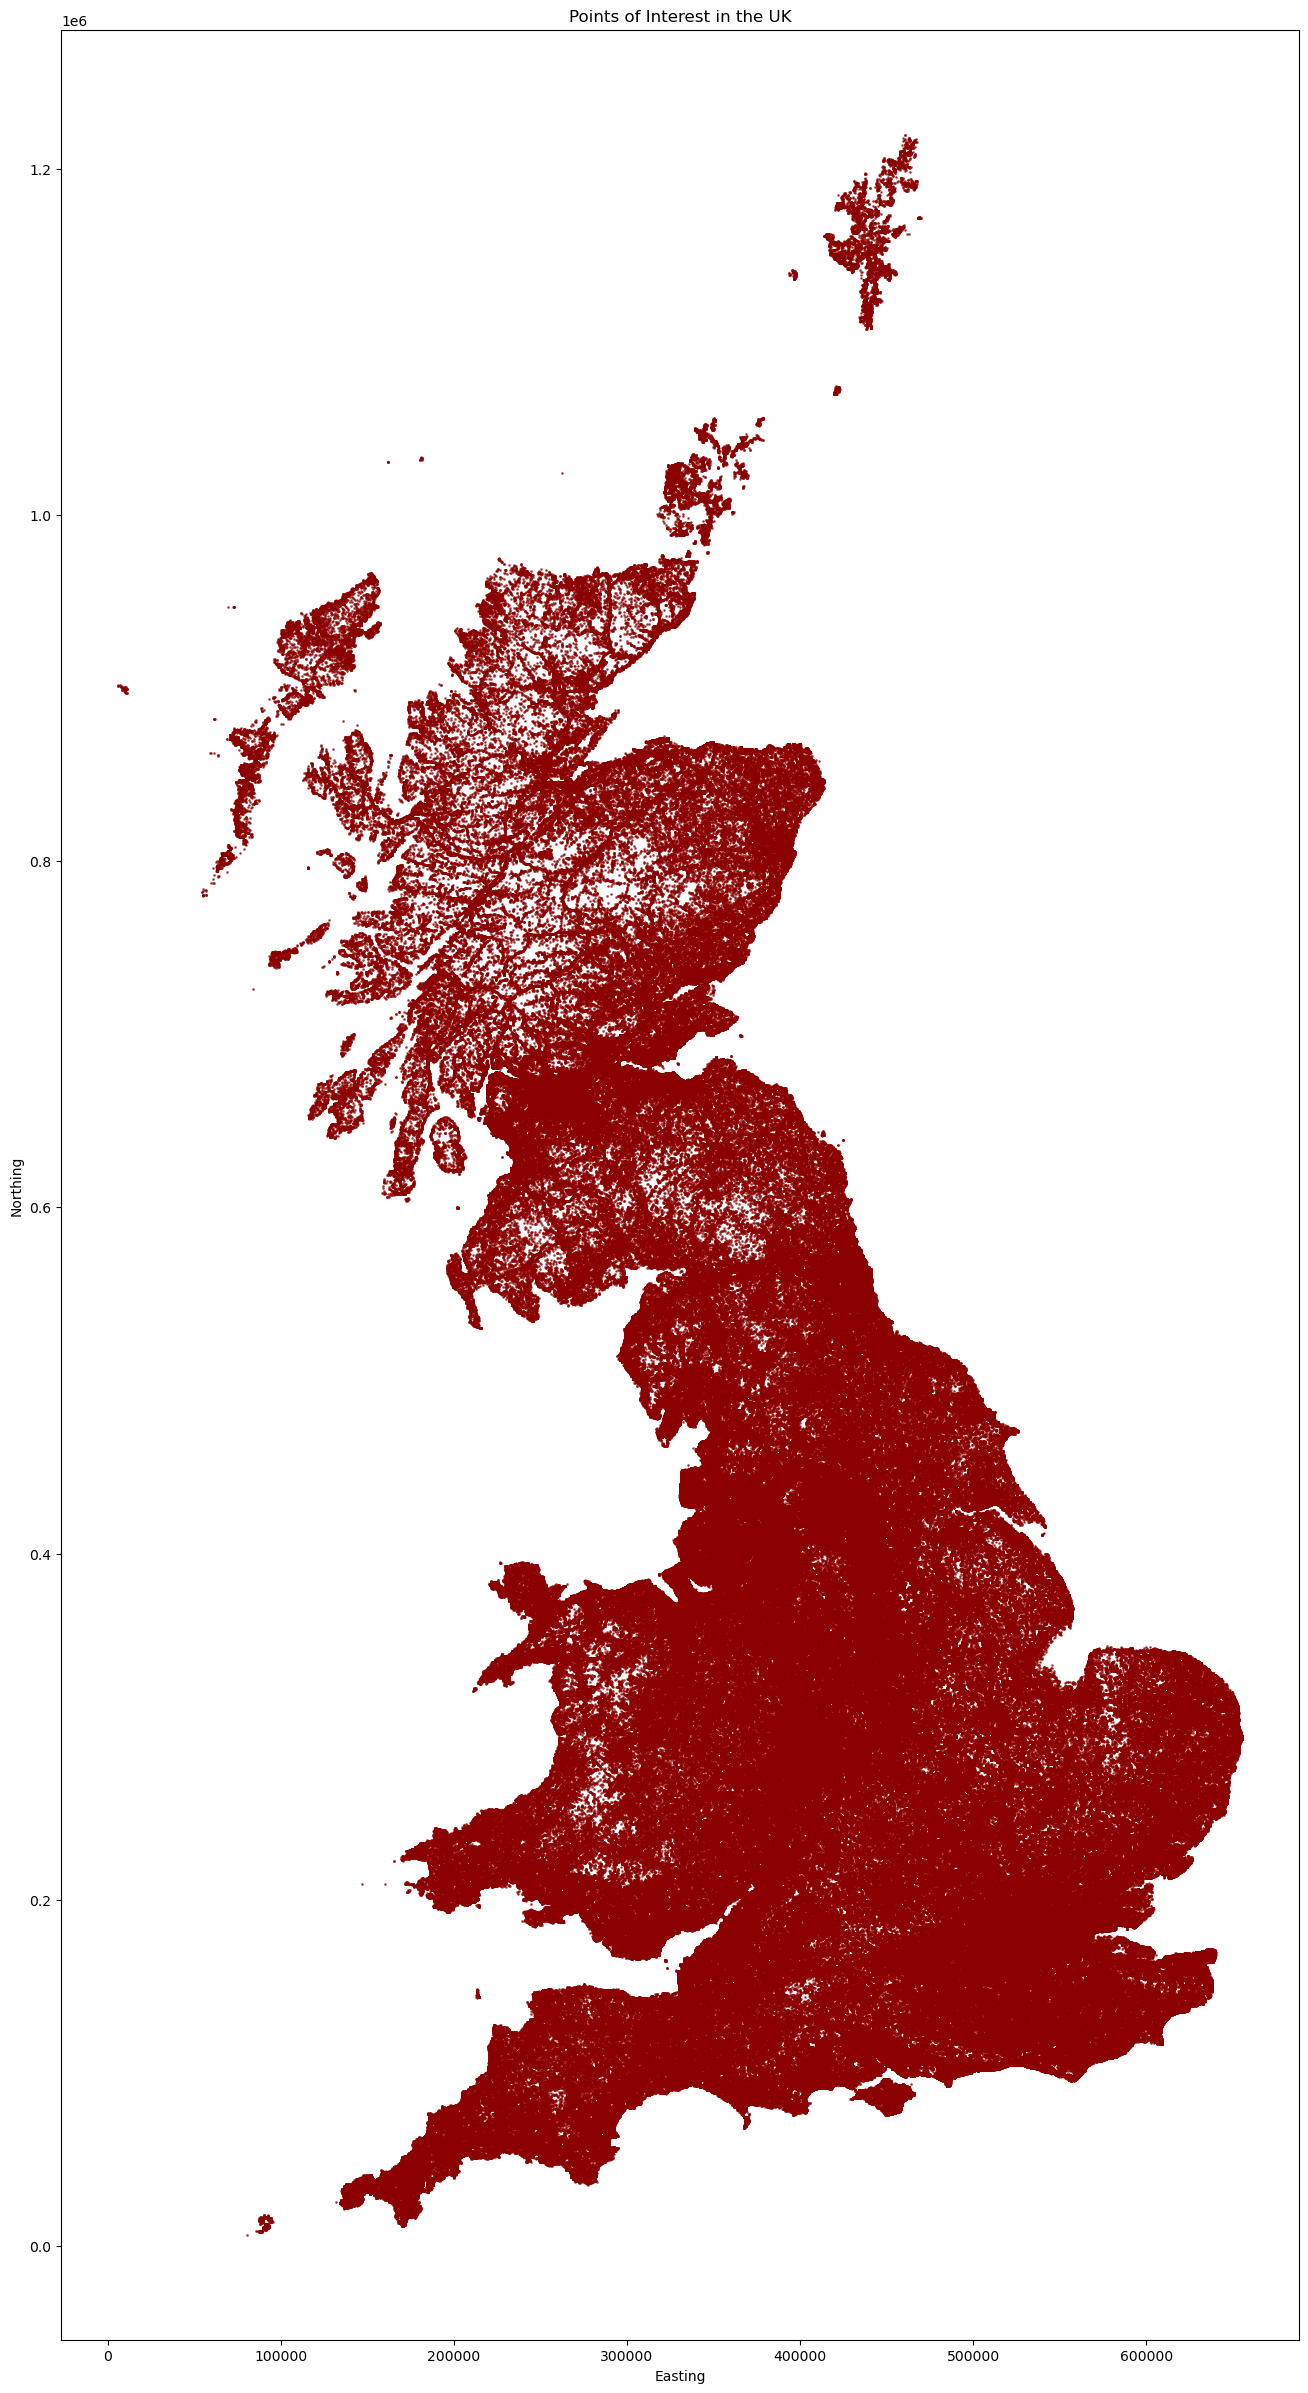

In [18]:
# plot
fig, ax = plt.subplots(figsize=(10, 15))
retail_gdf.plot(ax=ax, marker='o', color='#8B0000', markersize=1, alpha=0.4)

# title and labels
ax.set_title('Points of Interest in the UK')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

plt.show()

## 5. Exploratory Data Analysis: UK Retail POI Data

## 6. Convert to Graph Data
Possible Utility for Spatial Join Later in Analysis